In [1]:
import os

os.environ["OMP_NUM_THREADS"] = '12'

import torch
import torch.nn
import dgl
import os.path as osp
import GCL.losses as L
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
import GCL.augmentors as A
import torch
import torch.nn.functional as F

from torch import nn, tensor
from tqdm import tqdm
from torch.optim import Adam

from scipy.io import loadmat
from GCL.models.contrast_model import WithinEmbedContrast
from dgl.nn.pytorch import GATConv, GraphConv

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score


In [2]:
class inter_att(nn.Module):
    def __init__(self, hidden_dim, attn_drop):
        super(inter_att, self).__init__()
        self.fc = nn.Linear(hidden_dim, hidden_dim, bias=True)
        nn.init.xavier_normal_(self.fc.weight, gain=1.414)

        self.tanh = nn.Tanh()
        self.att = nn.Parameter(torch.empty(size=(1, hidden_dim)), requires_grad=True)
        nn.init.xavier_normal_(self.att.data, gain=1.414)

        self.softmax = nn.Softmax(dim=0)
        if attn_drop:
            self.attn_drop = nn.Dropout(attn_drop)
        else:
            self.attn_drop = lambda x: x

    def forward(self, embeds):
        beta = []
        attn_curr = self.attn_drop(self.att)
        for embed in embeds:
            sp = self.tanh(self.fc(embed)).mean(dim=0)
            beta.append(attn_curr.matmul(sp.t()))
        beta = torch.cat(beta, dim=-1).view(-1)
        beta = self.softmax(beta)
        # z = 0
        # for i in range(len(embeds)):
        #     z += embeds[i] * beta[i]
        return beta

class GConv(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2, num_heads=1):
        super(GConv, self).__init__()
        self.act = nn.SELU()
        self.num_layers = num_layers
        self.norm = nn.BatchNorm1d(num_heads * hidden_dim, momentum=0.01)
        self.layers = nn.ModuleList()
        self.layers.append(
            GraphConv(in_feats=input_dim, out_feats=hidden_dim, allow_zero_in_degree=True)
        )
        for _ in range(1, num_layers):
            self.layers.append(
                GraphConv(in_feats=num_heads * hidden_dim, out_feats=hidden_dim, allow_zero_in_degree=True)
            )
        self.register_buffer("epsilon", torch.FloatTensor([1e-12]))

    def forward(self, x, graph):
        z = x
        for i in range(self.num_layers):
            z = self.layers[i](graph, z)
            z = z.flatten(1)
            z = self.norm(z)
            z = self.act(z)
        # z = z / (torch.max(torch.norm(z, dim=1, keepdim=True), self.epsilon))
        # z = self.layers[-1](graph, z)
        return z


class Encoder(nn.Module):
    def __init__(self, graph_dict, augmentor, hidden_dim=256, n_clusters=3, num_heads=1):
        super(Encoder, self).__init__()

        gconvs = nn.ModuleDict()


        for k, v in graph_dict.items():
            gconv = GConv(input_dim=x.size(1), hidden_dim=hidden_dim, num_layers=3, num_heads=num_heads).to(device)
            gconvs[k] = gconv
        self.encoder = gconvs
        self.augmentor = augmentor
        self.register_buffer("epsilon", torch.FloatTensor([1e-12]))

        self.cluster_layer = nn.Parameter(torch.Tensor(n_clusters, num_heads * hidden_dim))
        self.v = 1
        self.device = torch.device('cuda')
        torch.nn.init.xavier_normal_(self.cluster_layer.data)

        self.alpha = 0.5

        self.attn = inter_att(hidden_dim=num_heads * hidden_dim, attn_drop=0)

    def forward(self, x, graph_dict, edge_weight=None):
        aug1, aug2 = self.augmentor
        zs = []
        z1s = []
        z2s = []
        qs = []
        for key, (graph, edge_index) in graph_dict.items():
            # if key != 'all':
                z = self.encoder[key](x, graph)

                x1, edge_index1, _ = aug1(x, edge_index)
                graph1 = dgl.graph((edge_index1[0], edge_index1[1])).to(self.device)
                z1 = self.encoder[key](x1, graph1)

                x2, edge_index2, _ = aug2(x, edge_index)
                graph2 = dgl.graph((edge_index2[0], edge_index2[1])).to(self.device)
                z2 = self.encoder[key](x2, graph2)

                zs.append(z)
                z1s.append(z1)
                z2s.append(z2)

                q = 1.0 / (1.0 + torch.sum(torch.pow(z.unsqueeze(1) - self.cluster_layer, 2), 2) / self.v)
                q = q.pow((self.v + 1.0) / 2.0)
                q = (q.t() / torch.sum(q, 1)).t()

                qs.append(q)
        beta = self.attn(zs)
        z = 0
        for i in range(len(zs)):
            z += zs[i] * beta[i]
        return z, z1s, z2s, qs, beta


In [3]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()



In [4]:

device = torch.device('cuda')
path = osp.join(osp.pardir, 'datasets', 'ACM')

mat = loadmat(osp.join(path, 'ACM3025.mat'))
print(mat.keys())


dict_keys(['__header__', '__version__', '__globals__', 'PAP', 'PLP', 'PMP', 'PTP', 'feature', 'label', 'test_idx', 'train_idx', 'val_idx'])


In [5]:
print(len(mat['train_idx'][0]))

600


In [6]:
# edge_index = []
# for i in tqdm(range(len(mat['PLP']))):
#     for j in range(len(mat['PLP'])):
#         if mat['PAP'][i][j] == 1:
#             edge_index.append([i, j])

graph_dict = {}
all_edge_index = []
for etype in ['PAP', 'PLP']:
    edge_index = []
    for i in tqdm(range(len(mat[etype]))):
        for j in range(len(mat[etype])):
            if mat[etype][i][j] == 1:
                edge_index.append([i, j])
                all_edge_index.append([i, j])
    print(len(edge_index))
    edge_index = tensor(edge_index, dtype=torch.long).t().contiguous()
    graph = dgl.graph((edge_index[0], edge_index[1])).to(device)
    graph_dict[etype] = (graph, edge_index)

# all_edge_index = tensor(all_edge_index, dtype=torch.long).t().contiguous()
# graph_dict['all'] = (dgl.graph((all_edge_index[0], all_edge_index[1])).to(device), all_edge_index)

100%|██████████| 3025/3025 [00:15<00:00, 194.26it/s]


29281


100%|██████████| 3025/3025 [00:15<00:00, 197.10it/s]


2210761


In [7]:
print(graph_dict)

{'PAP': (Graph(num_nodes=3025, num_edges=29281,
      ndata_schemes={}
      edata_schemes={}), tensor([[   0,    0,    0,  ..., 3024, 3024, 3024],
        [   0,    8,   20,  ..., 2983, 2991, 3024]])), 'PLP': (Graph(num_nodes=3025, num_edges=2210761,
      ndata_schemes={}
      edata_schemes={}), tensor([[   0,    0,    0,  ..., 3024, 3024, 3024],
        [   0,   75,  434,  ..., 3021, 3022, 3024]]))}


In [8]:
x = tensor(mat['feature'], dtype=torch.float).to(device)
y = torch.argmax(tensor(mat['label']), -1).to(device)
train_idx = tensor(mat['train_idx'], dtype=torch.int64).flatten().to(device)
val_idx = tensor(mat['val_idx'], dtype=torch.int64).flatten().to(device)
test_idx = tensor(mat['test_idx'], dtype=torch.int64).flatten().to(device)
print(train_idx.size())
train_mask = torch.index_fill(torch.zeros_like(y), index=train_idx, value=1, dim=0)
val_mask = torch.index_fill(torch.zeros_like(y), index=val_idx, value=1, dim=0)
test_mask = torch.index_fill(torch.zeros_like(y), index=test_idx, value=1, dim=0)


torch.Size([600])


In [9]:
del mat


model have 1288960 paramerters in total


(T): 100%|██████████| 300/300 [03:02<00:00,  1.65it/s, loss=3.38, con_loss=45.5, kl_loss=0.22] 


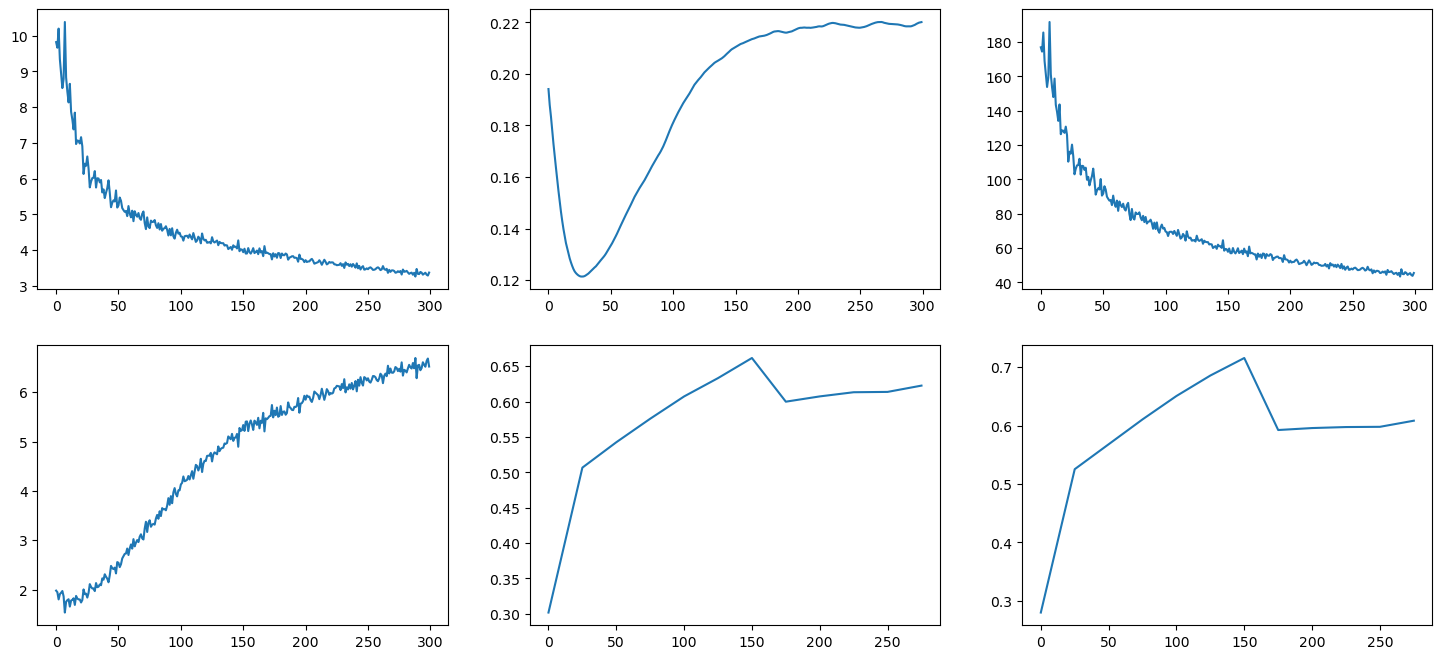

[MAX]NMI:  0.6615935569980905
[MAX]ARI:  0.715529566049227


In [10]:

def train(encoder_model, contrast_model, optimizer, x, graph_dict, p):
    encoder_model.train()
    optimizer.zero_grad()
    _, z1s, z2s, qs, beta = encoder_model(x, graph_dict)
    con_loss = 0
    for i in range(len(z1s)):
        con_loss += contrast_model(z1s[i], z2s[i])
    kl_loss = 0
    for i in range(len(qs)):
        kl_loss += F.kl_div(qs[i].log(), p, reduction='batchmean')

    # con_loss = 0.01 * con_loss
    loss = (0.1 * con_loss + 10 * kl_loss) / len(qs)

    loss.backward()
    optimizer.step()
    return loss.item(), con_loss.item(), kl_loss.item()


aug1 = A.Compose([A.EdgeRemoving(pe=0.5), A.FeatureMasking(pf=0.3)])
aug2 = A.Compose([A.EdgeRemoving(pe=0.5), A.FeatureMasking(pf=0.3)])

encoder_model = Encoder(graph_dict=graph_dict, augmentor=(aug1, aug2), hidden_dim=256, num_heads=1).to(device)
print("model have {} paramerters in total".format(sum(x.numel() for x in encoder_model.parameters())))

contrast_model = WithinEmbedContrast(loss=L.BarlowTwins()).to(device)

# optimizer = Adam(encoder_model.parameters(), lr=5e-4)
optimizer = Adam(encoder_model.parameters(), lr=0.0001, weight_decay=5e-5)
losss = []
kl_losss = []
con_losss = []
nmis = []
aris = []
ratios = []
epochs = 300

kmeans = KMeans(n_clusters=3, n_init=20)

with torch.no_grad():
    z, _, _, _, _ = encoder_model(x, graph_dict)
_ = kmeans.fit_predict(z.data.cpu().numpy())
encoder_model.cluster_layer.data = torch.tensor(kmeans.cluster_centers_).to(device)

with tqdm(total=epochs, desc='(T)') as pbar:
    for epoch in range(epochs):
        encoder_model.train()
        if epoch % 1 == 0:
            # update_interval
            _, _, _, tmp_q, _ = encoder_model(x, graph_dict)
            data = 0
            for q in tmp_q:
                data += q
            data = data / len(tmp_q)
            p = target_distribution(data.data)


        loss, con_loss, kl_loss = train(encoder_model, contrast_model, optimizer, x, graph_dict, p)
        pbar.set_postfix({'loss': loss, 'con_loss': con_loss, 'kl_loss': kl_loss})
        pbar.update()
        losss.append(loss)
        kl_losss.append(kl_loss)
        con_losss.append(con_loss)
        ratios.append((100 * kl_loss) / loss)

        if epoch % 25 == 0:
            with torch.no_grad():
                encoder_model.eval()
                z, _, _, _, beta = encoder_model(x, graph_dict)
            pred = kmeans.fit_predict(z.cpu())
            nmi = normalized_mutual_info_score(pred, y.cpu())
            ari = adjusted_rand_score(pred, y.cpu())
            nmis.append((epoch, nmi))
            aris.append((epoch, ari))


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
axes[0][0].plot(range(epochs), losss)
axes[0][1].plot(range(epochs), kl_losss)
axes[0][2].plot(range(epochs), con_losss)
axes[1][0].plot(range(epochs), ratios)
axes[1][1].plot([i[0] for i in nmis], [i[1] for i in nmis])
axes[1][2].plot([i[0] for i in aris], [i[1] for i in aris])
plt.show()
print('[MAX]NMI: ', max([i[1] for i in nmis]))
print('[MAX]ARI: ', max([i[1] for i in aris]))
# test_result = test(encoder_model, data)
# print(f'(E): Best test F1Mi={test_result["micro_f1"]:.4f}, F1Ma={test_result["macro_f1"]:.4f}')


In [11]:

with torch.no_grad():
    encoder_model.eval()
    z, _, _, qs, _ = encoder_model(x, graph_dict)

pred = kmeans.fit_predict(z.cpu())

nmi = normalized_mutual_info_score(pred, y.cpu())
print('[INFO]NMI: ', nmi)

ari = adjusted_rand_score(pred, y.cpu())
print('[INFO]ARI: ', ari)




[INFO]NMI:  0.6201847183982286
[INFO]ARI:  0.6099796759966543


In [12]:

pred = kmeans.fit_predict(x.cpu())

nmi = normalized_mutual_info_score(pred, y.cpu())
print('[INFO]NMI: ', nmi)

ari = adjusted_rand_score(pred, y.cpu())
print('[INFO]ARI: ', ari)

[INFO]NMI:  0.32276130182852775
[INFO]ARI:  0.3001006063201963
